## Spatial Correlations test

In [324]:
from pathlib import Path
import numpy as np
import pandas as pd
import math
from numba import njit
import time
from matplotlib import pyplot as plt
from pytransform3d import rotations as pyro
from matplotlib.image import NonUniformImage
import yaml

In [706]:
# Define paths
path_prefix = Path("/Users/saadjansari/Documents/Projects/Results/AMSOS")
simpath = {
    'Tac': path_prefix / "Tactoids/scan_filamin_6400/run/f10_merged",
    'C_aster': path_prefix / "Confinement/scan_d_pf_const_num/run/pf08_d30/s0_c",
    'C_psb': path_prefix / "Confinement/scan_d_pf_const_num/run/pf08_d125/s0_c",
}

# resolve paths
for key in simpath.keys():
    simpath[key].resolve()

#### Accessory functions:

In [707]:
def get_volume_from_config(spath, conf=False):
    # Read yaml config file to extract information about space
    # If confinement is True, use a cylindrical confinement in XY plane, but full box size in Z
    with open( spath / 'RunConfig.yaml') as yf:
        rconfig = yaml.safe_load( yf)
        
    box_size = np.array( rconfig['simBoxHigh']) - np.array( rconfig['simBoxLow'])
    
    if conf:
        cyl_length = box_size[ np.array( rconfig['boundaries'][0]['axis'], dtype=bool)]
        cyl_rad = rconfig['boundaries'][0]['radius']
        vol = math.pi * cyl_rad**2 * cyl_length
        vol = vol[0]
    else:
        vol = boxsize[0]*boxsize[1]*boxsize[2]
    
    return vol

def get_boxsize_pbc(spath, conf=False):
    # Read yaml config file to extract information about space
    # If confinement is True, use a cylindrical confinement in XY plane, but full box size in Z
    with open( spath / 'RunConfig.yaml') as yf:
        rconfig = yaml.safe_load( yf)
        
    box_size = np.array( rconfig['simBoxHigh']) - np.array( rconfig['simBoxLow'])
    if conf:
        box_size[0] = 2*box_size[0]
        box_size[1] = 2*box_size[1]
    return box_size
    
def find_last_frame(spath):
    
    def fileKey(f):
        return int( f.parts[-1].split('_')[-1].split('.dat')[0] )
    file_s_last = sorted( list(spath.glob('**/SylinderAscii*')), key=fileKey)[-1]
    file_p_last = sorted( list(spath.glob('**/ProteinAscii*')), key=fileKey)[-1]
    return file_s_last, file_p_last

def read_dat_sylinder( fname):
    # Read a SylinderAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Initialize numpy arrays for data
        gids = np.zeros( len(filecontent)-2, dtype=int)
        rad = np.zeros(len(filecontent)-2)
        pos0 = np.zeros( (len(filecontent)-2,3))
        pos1 = np.zeros( (len(filecontent)-2,3))
        ort = np.zeros( (len(filecontent)-2,3))

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []
        for idx,line in enumerate(filecontent):

            # Split the string with space-delimited and convert strings into useful data types
            data = line.split()
            gids[idx] = int(data[1])

            dat = np.array( list(map(float,data[2::])) )
            rad[idx] = dat[0]
            pos0[idx,:] = dat[1:4]
            pos1[idx,:] = dat[4::]
            xi = pos1[idx,:] - pos0[idx,:]
            ort[idx,:] =  xi/np.sqrt(xi.dot(xi))

    # Store data as a dataframe
    df = pd.DataFrame({
        'gid': gids,
        'radius' : rad,
        'pos0' : list(pos0),
        'pos1': list(pos1),
        'orientation': list(ort)
        })
    return df

def read_dat_protein( fname):
    # Read a ProetinAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []

        # Initialize numpy arrays for data
        gids = np.zeros( len(filecontent), dtype=int)
        pos0 = np.zeros( (len(filecontent),3))
        pos1 = np.zeros( (len(filecontent),3))
        link0 = np.zeros( len(filecontent), dtype=int)
        link1 = np.zeros( len(filecontent), dtype=int)

        for idx,line in enumerate(filecontent):

            # Split the string with space-delimited and convert strings into useful data types
            data = line.split()
            # pdb.set_trace()
            gids[idx] = int(data[1])
            link0[idx] = int(data[9])
            link1[idx] = int(data[10])
            dat = np.array( list(map(float,data[2:9])) )
            pos0[idx,:] = dat[1:4]
            pos1[idx,:] = dat[4::]

    # Store data as a dataframe
    df = pd.DataFrame({
        'gid': gids,
        'pos0' : list(pos0),
        'pos1': list(pos1),
        'link0': link0,
        'link1': link1
        })
    return df

In [708]:
@njit
def calc_distance_pbc(p0,p1,boxsize):
    # distance between two points in the nearest image convention
    # can use multidimensional arrays for distances between multiple points
    dist = np.absolute( p1-p0)
    for idx in np.arange(dist.shape[-1]):
        if len(dist.shape) == 1:
            k = np.floor( dist[idx]/(0.5*boxsize[idx]))
            dist[idx] -= k*boxsize[idx]
        elif len(dist.shape) == 2:
            k = np.floor( dist[:,idx]/(0.5*boxsize[idx]))
            dist[:,idx] -= k*boxsize[idx]
    return np.absolute(dist)

@njit
def unfold_coordinates(crds,c_ref,boxsize):
    # unfolded crds via the nearest image convention

    # reference coordinate
    dist = crds-c_ref
    for idx in np.arange(crds.shape[-1]):
        k = np.sign( dist[:,idx]) * np.floor( np.absolute(dist[:,idx])/(0.5*boxsize[idx]))
        crds[:,idx] -= k*boxsize[idx]
    return crds

def transform_coords( coords, origin_new, axis_new):
    # transform coordinates to a new frame of reference with the orivided
    # new origin and the the new basis matrix

    # Translate origin
    coords = coords - origin_new

    # Get vector perp to z-axis and the new z-axis
    vperp = pyro.perpendicular_to_vectors( np.array([0,0,1]), axis_new)

    # Rotate if needed
    if np.linalg.norm( vperp) >0.00001:
        vperp = vperp / np.linalg.norm(vperp)
        theta = pyro.angle_between_vectors( np.array([0,0,1]), axis_new)
        axis_angle = np.concatenate( (vperp, -np.array([theta]) ))
        q = pyro.quaternion_from_axis_angle( axis_angle)

        # transfrom coordinates
        coords = q_prod_coords( coords,q )

    return coords

@njit
def q_prod_coords( coords, q):
    # multiply each row vector in coords by the quaternion q
    for idx in np.arange( coords.shape[0]):
        t = 2 * np.cross(q[1:], coords[idx,:])
        coords[idx,:]+= q[0] * t + np.cross(q[1:], t)
    return coords

def calc_cyl_corr_single( c_ref, c_all, idx_exclude, boxsize, axis_cyl=np.array([0,0,1])):
    # calculates a binned (x^2+y^2) vs z binned matrix for distributions of points relative to reference point.

    c_tall = unfold_coordinates(c_all[ np.arange(c_all.shape[0])!=idx_exclude], c_ref,boxsize)-c_ref
    # transform all other coordinates
    c_tall = transform_coords(
        c_tall,
        np.array([0,0,0]),
        axis_cyl)
    x2y2sqrt = np.sqrt( c_tall[:,0]**2 + c_tall[:,1]**2 )
    z = c_tall[:,2]
    return x2y2sqrt, z

def calc_cyl_corr( c_all, orients, boxsize, **kwargs):
    # calculates a binned (x^2+y^2) vs z binned matrix for all pairs of distributions of points


    sz = c_all.shape[0]
    xyall = np.zeros( sz*(sz-1))
    zall = np.zeros( sz*(sz-1))
    for idx in np.arange(sz):
        if 'axis_cyl' in kwargs.keys():
            new_axis = kwargs['axis_cyl']
        else:
            new_axis = orients[idx,:] 
        xyall[idx*(sz-1):idx*(sz-1)+(sz-1)], zall[idx*(sz-1):idx*(sz-1)+(sz-1)] = calc_cyl_corr_single(
                c_all[idx,:],
                c_all, idx, boxsize, new_axis)
    return xyall, zall

# radial distribution function
def calc_rdf_single( c_ref, c_all, boxsize):
    # calculates a binned (x^2+y^2) vs z binned matrix for distributions of points relative to reference point.
    c_tall = unfold_coordinates(c_all, c_ref, boxsize)-c_ref
    r = np.sqrt( c_tall[:,0]**2 + c_tall[:,1]**2 + c_tall[:,2]**2 )
    return r

def calc_rdf( c_all, boxsize):
    # calculates distances for all pairs of distributions of points

    sz = c_all.shape[0]
    rall = np.zeros( sz*(sz-1))
    for idx in np.arange(sz):
        c_aall = c_all[ np.arange(c_all.shape[0])!=idx]
        rall[idx*(sz-1):idx*(sz-1)+(sz-1)] = calc_rdf_single(
                c_all[idx,:],c_aall, boxsize)
    return rall

#### Confined Aster:

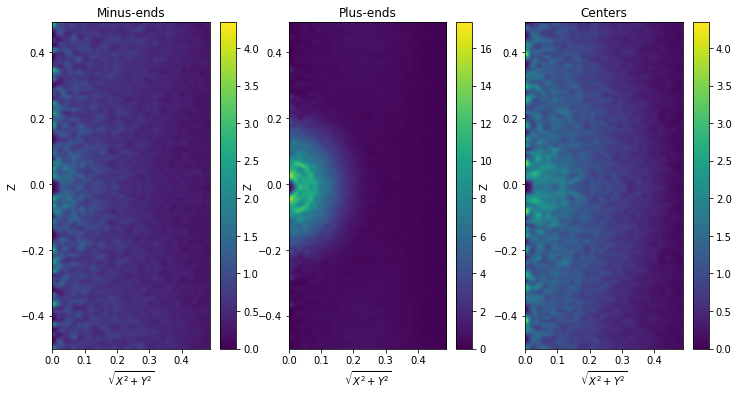

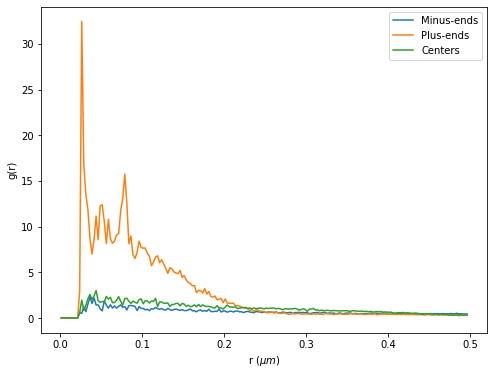

In [709]:
# Load data
key = 'C_aster'
conf = True
vol = get_volume_from_config(simpath[key], 
                             conf=conf)
boxsize = get_boxsize_pbc( simpath[key],
                         conf=conf)

df_sylinder = read_dat_sylinder( find_last_frame( simpath[key])[0] )
df_protein = read_dat_protein(find_last_frame( simpath[key])[1])
n = df_sylinder.shape[0]

xyedges = np.arange(0,0.5,0.0125)
zedges = np.arange(-boxsize[2]/2,boxsize[2]/2,0.01)
W = np.outer( math.pi*(xyedges[1:]**2 - xyedges[:-1]**2), (zedges[1:]-zedges[:-1]) )

fig,ax = plt.subplots(1,3,figsize=(12, 6))

# Minus ends
xy,z = calc_cyl_corr( 
    np.array( df_sylinder.pos0.tolist()),
    np.array( df_sylinder.orientation.tolist()),
    boxsize,
    axis_cyl=np.array([0,0,1]))

H,xyedges,zedges = np.histogram2d(xy,z, bins=(xyedges, zedges) )
H = vol*H/(W*n*n)

img = ax[0].imshow(H.T, cmap='viridis', interpolation='bicubic', aspect="auto",
        extent=[xyedges[0], xyedges[-1], zedges[0], zedges[-1]])
ax[0].set(xlabel='$\sqrt{X^2 + Y^2}$', ylabel='Z')
fig.colorbar(img, ax=ax[0])
ax[0].set(title='Minus-ends')

# Plus ends
xy,z = calc_cyl_corr( 
    np.array( df_sylinder.pos1.tolist()),
    np.array( df_sylinder.orientation.tolist()),
    boxsize,
    axis_cyl=np.array([0,0,1]))

H,xyedges,zedges = np.histogram2d(xy,z, bins=(xyedges, zedges) )
H = vol*H/(W*n*n)
img = ax[1].imshow(H.T, cmap='viridis', interpolation='bicubic', aspect="auto",
        extent=[xyedges[0], xyedges[-1], zedges[0], zedges[-1]])
ax[1].set(xlabel='$\sqrt{X^2 + Y^2}$', ylabel='Z')
fig.colorbar(img, ax=ax[1])
ax[1].set(title='Plus-ends')

# Centers
xy,z = calc_cyl_corr( 
    (np.array( df_sylinder.pos0.tolist()) + np.array( df_sylinder.pos1.tolist()))/2,
    np.array( df_sylinder.orientation.tolist()),
    boxsize,
    axis_cyl=np.array([0,0,1]))

H,xyedges,zedges = np.histogram2d(xy,z, bins=(xyedges, zedges) )
H = vol*H/(W*n*n)
img = ax[2].imshow(H.T, cmap='viridis', interpolation='bicubic', aspect="auto",
        extent=[xyedges[0], xyedges[-1], zedges[0], zedges[-1]])
ax[2].set(xlabel='$\sqrt{X^2 + Y^2}$', ylabel='Z')
fig.colorbar(img, ax=ax[2])
ax[2].set(title='Centers')

# Radial distirbution function
fig,ax = plt.subplots(figsize=(8, 6))
redges = np.arange(0,0.5,0.0025)
W = (4/3)*math.pi*(redges[1:]**3 - redges[:-1]**3)

# Minus ends
r = calc_rdf( np.array( df_sylinder.pos0.tolist()),
             box_size)
H2,redges = np.histogram(r, bins=redges)
Ha = vol*H2/(W*n*n)

# Plus ends
r = calc_rdf( np.array( df_sylinder.pos1.tolist()),
             box_size)
H2,redges = np.histogram(r, bins=redges)
Hb = vol*H2/(W*n*n)

# Centers
r = calc_rdf( (np.array( df_sylinder.pos0.tolist()) + np.array( df_sylinder.pos1.tolist()))/2,
             box_size)
H2,redges = np.histogram(r, bins=redges)
Hc = vol*H2/(W*n*n)

ax.plot((redges[1:]+redges[:-1])/2,Ha, label='Minus-ends')
ax.plot((redges[1:]+redges[:-1])/2,Hb, label='Plus-ends')
ax.plot((redges[1:]+redges[:-1])/2,Hc, label='Centers')
ax.set(ylabel='g(r)', xlabel='r ($\mu m$)')
plt.legend()

#### Confined PSB

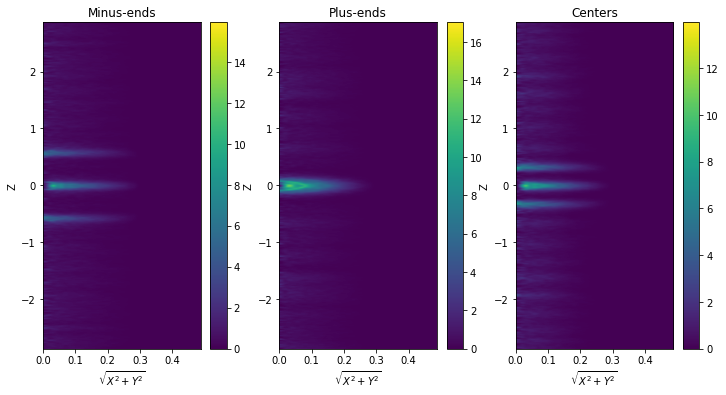

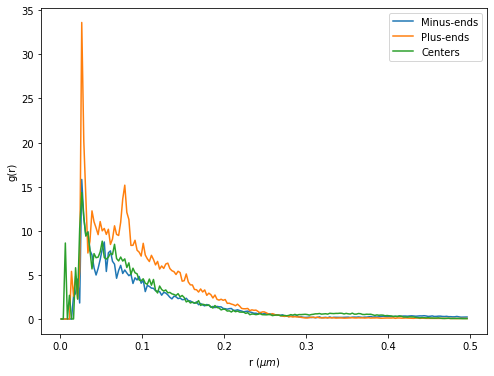

In [710]:
# Load data
key = 'C_psb'
conf = True
vol = get_volume_from_config(simpath[key], 
                             conf=conf)
boxsize = get_boxsize_pbc( simpath[key],
                         conf=conf)

df_sylinder = read_dat_sylinder( find_last_frame( simpath[key])[0] )
df_protein = read_dat_protein(find_last_frame( simpath[key])[1])
n = df_sylinder.shape[0]

xyedges = np.arange(0,0.5,0.0125)
zedges = np.arange(-boxsize[2]/2,boxsize[2]/2,0.01)
W = np.outer( math.pi*(xyedges[1:]**2 - xyedges[:-1]**2), (zedges[1:]-zedges[:-1]) )

fig,ax = plt.subplots(1,3,figsize=(12, 6))

# Minus ends
xy,z = calc_cyl_corr( 
    np.array( df_sylinder.pos0.tolist()),
    np.array( df_sylinder.orientation.tolist()),
    boxsize,
    axis_cyl=np.array([0,0,1]))

H,xyedges,zedges = np.histogram2d(xy,z, bins=(xyedges, zedges) )
H = vol*H/(W*n*n)

img = ax[0].imshow(H.T, cmap='viridis', interpolation='bicubic', aspect="auto",
        extent=[xyedges[0], xyedges[-1], zedges[0], zedges[-1]])
ax[0].set(xlabel='$\sqrt{X^2 + Y^2}$', ylabel='Z')
fig.colorbar(img, ax=ax[0])
ax[0].set(title='Minus-ends')

# Plus ends
xy,z = calc_cyl_corr( 
    np.array( df_sylinder.pos1.tolist()),
    np.array( df_sylinder.orientation.tolist()),
    boxsize,
    axis_cyl=np.array([0,0,1]))

H,xyedges,zedges = np.histogram2d(xy,z, bins=(xyedges, zedges) )
H = vol*H/(W*n*n)
img = ax[1].imshow(H.T, cmap='viridis', interpolation='bicubic', aspect="auto",
        extent=[xyedges[0], xyedges[-1], zedges[0], zedges[-1]])
ax[1].set(xlabel='$\sqrt{X^2 + Y^2}$', ylabel='Z')
fig.colorbar(img, ax=ax[1])
ax[1].set(title='Plus-ends')

# Centers
xy,z = calc_cyl_corr( 
    (np.array( df_sylinder.pos0.tolist()) + np.array( df_sylinder.pos1.tolist()))/2,
    np.array( df_sylinder.orientation.tolist()),
    boxsize,
    axis_cyl=np.array([0,0,1]))

H,xyedges,zedges = np.histogram2d(xy,z, bins=(xyedges, zedges) )
H = vol*H/(W*n*n)
img = ax[2].imshow(H.T, cmap='viridis', interpolation='bicubic', aspect="auto",
        extent=[xyedges[0], xyedges[-1], zedges[0], zedges[-1]])
ax[2].set(xlabel='$\sqrt{X^2 + Y^2}$', ylabel='Z')
fig.colorbar(img, ax=ax[2])
ax[2].set(title='Centers')

# Radial distirbution function
fig,ax = plt.subplots(figsize=(8, 6))
redges = np.arange(0,0.5,0.0025)
W = (4/3)*math.pi*(redges[1:]**3 - redges[:-1]**3)

# Minus ends
r = calc_rdf( np.array( df_sylinder.pos0.tolist()),
             box_size)
H2,redges = np.histogram(r, bins=redges)
Ha = vol*H2/(W*n*n)

# Plus ends
r = calc_rdf( np.array( df_sylinder.pos1.tolist()),
             box_size)
H2,redges = np.histogram(r, bins=redges)
Hb = vol*H2/(W*n*n)

# Centers
r = calc_rdf( (np.array( df_sylinder.pos0.tolist()) + np.array( df_sylinder.pos1.tolist()))/2,
             box_size)
H2,redges = np.histogram(r, bins=redges)
Hc = vol*H2/(W*n*n)


ax.plot((redges[1:]+redges[:-1])/2,Ha, label='Minus-ends')
ax.plot((redges[1:]+redges[:-1])/2,Hb, label='Plus-ends')
ax.plot((redges[1:]+redges[:-1])/2,Hc, label='Centers')
ax.set(ylabel='g(r)', xlabel='r ($\mu m$)')
plt.legend()

#### Tactoid

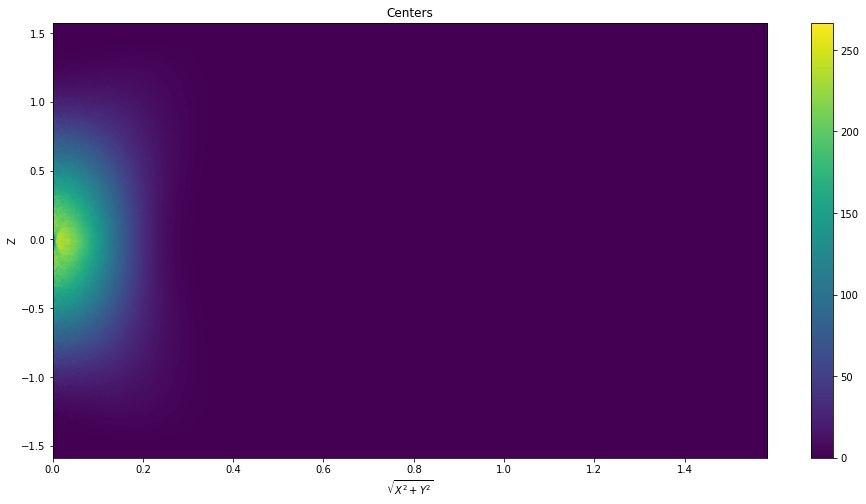

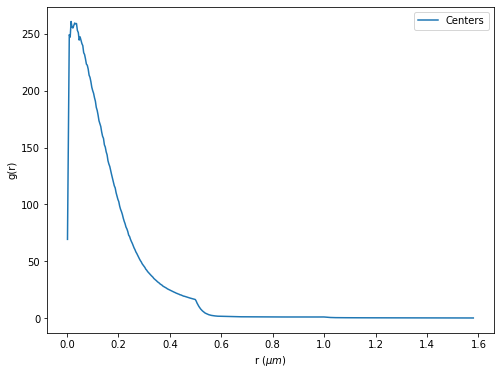

In [699]:
# Load data
key = 'Tac'
conf = False
vol = get_volume_from_config(simpath[key], 
                             conf=conf)
boxsize = get_boxsize_pbc( simpath[key],
                         conf=conf)

df_sylinder = read_dat_sylinder( find_last_frame( simpath[key])[0] )
df_protein = read_dat_protein(find_last_frame( simpath[key])[1])
n = df_sylinder.shape[0]

xyedges = np.arange(0,boxsize[2]/2,0.0035)
zedges = np.arange(-boxsize[2]/2,boxsize[2]/2,0.01)
W = np.outer( math.pi*(xyedges[1:]**2 - xyedges[:-1]**2), (zedges[1:]-zedges[:-1]) )

fig,ax = plt.subplots(figsize=(16, 8))

# Centers
xy,z = calc_cyl_corr( 
    (np.array( df_sylinder.pos0.tolist()) + np.array( df_sylinder.pos1.tolist()))/2,
    np.array( df_sylinder.orientation.tolist()),
    boxsize,
    axis_cyl=np.array([0,0,1]))

H,xyedges,zedges = np.histogram2d(xy,z, bins=(xyedges, zedges) )
H = vol*H/(W*n*n)
img = ax.imshow(H.T, cmap='viridis', interpolation='bicubic', aspect="auto",
        extent=[xyedges[0], xyedges[-1], zedges[0], zedges[-1]])
ax.set(xlabel='$\sqrt{X^2 + Y^2}$', ylabel='Z')
fig.colorbar(img, ax=ax)
ax.set(title='Centers')

# Radial distirbution function
fig,ax = plt.subplots(figsize=(8, 6))
redges = np.arange(0,boxsize[2]/2,0.0035)
W = (4/3)*math.pi*(redges[1:]**3 - redges[:-1]**3)

# Centers
r = calc_rdf( (np.array( df_sylinder.pos0.tolist()) + np.array( df_sylinder.pos1.tolist()))/2,
             box_size)
H2,redges = np.histogram(r, bins=redges)
Hc = vol*H2/(W*n*n)

ax.plot((redges[1:]+redges[:-1])/2,Hc, label='Centers')

ax.set(ylabel='g(r)', xlabel='r ($\mu m$)')
plt.legend()

### Test: rotations

In [192]:
# Create fake data

# Random points on a circle/sphere
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim,npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec
pos0 = sample_spherical(100,ndim=3).T
pos1 = 1.5*pos0
orients = pos1-pos0

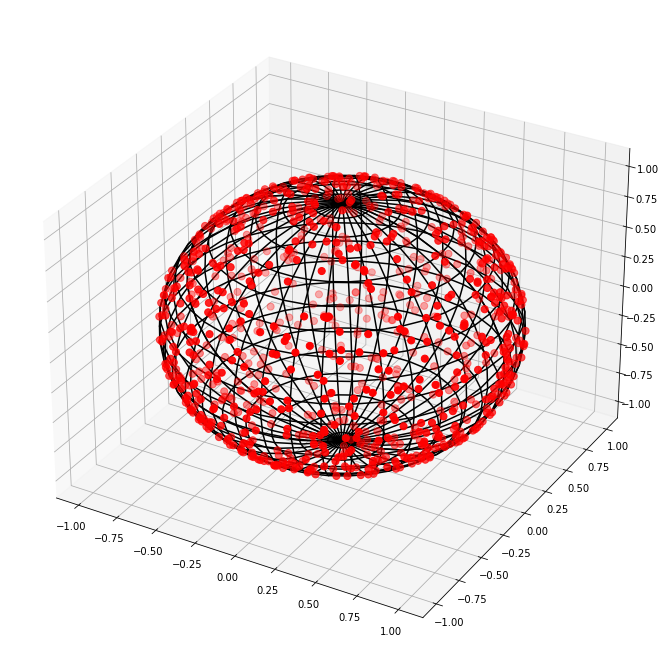

In [187]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))
xi, yi, zi = sample_spherical(1000)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(12,12))
ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(xi, yi, zi, s=50, c='r', zorder=10)

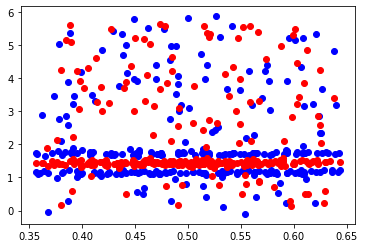

In [310]:
# Load data
key = 'C_psb'
# boxsize = np.array([20,20,10])
boxsize = np.array([3.17,3.17,3.17])

df_sylinder = read_dat_sylinder( find_last_frame( simpath[key])[0] )
df_protein = read_dat_protein(find_last_frame( simpath[key])[1])
minus = np.array( df_sylinder.pos0.tolist())
plus = np.array( df_sylinder.pos1.tolist())

plt.scatter(minus[:,0], minus[:,2], color='blue')
plt.scatter(plus[:,0], plus[:,2], color='red')

In [618]:
# Load data
key = 'C_psb'
conf = True
vol = get_volume_from_config(simpath[key], 
                             conf=conf)
# boxsize = np.array([20,20,10])
boxsize = get_boxsize_pbc( simpath[key],
                         conf=conf)

df_sylinder = read_dat_sylinder( find_last_frame( simpath[key])[0] )
df_protein = read_dat_protein(find_last_frame( simpath[key])[1])
n = df_sylinder.shape[0]

xy,z = calc_cyl_corr( 
    np.array( df_sylinder.pos0.tolist()),
    np.array( df_sylinder.orientation.tolist()),
    boxsize,
    axis_cyl=np.array([0,0,1]))

xyedges = np.arange(0,0.5,0.0125)
zedges = np.arange(-boxsize[2]/2,boxsize[2]/2,0.1)
W = np.outer( math.pi*(xyedges[1:]**2 - xyedges[:-1]**2), (zedges[1:]-zedges[:-1]) )
H,xyedges,zedges = np.histogram2d(xy,z, bins=(xyedges, zedges) )
H = vol*H/(W*n*n)

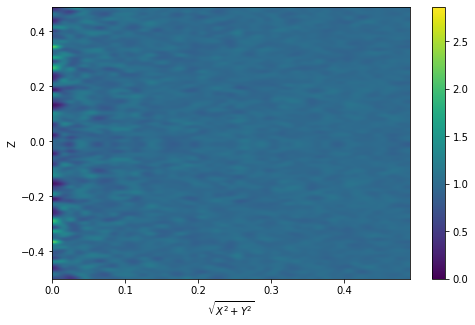

In [701]:
def calc_cyl_corr_single( c_ref, c_all, idx_exclude, boxsize, axis_cyl=np.array([0,0,1])):
    # calculates a binned (x^2+y^2) vs z binned matrix for distributions of points relative to reference point.

    c_tall = unfold_coordinates(c_all[ np.arange(c_all.shape[0])!=idx_exclude], c_ref,boxsize)-c_ref
    # transform all other coordinates
    c_tall = transform_coords(
        c_tall,
        np.array([0,0,0]),
        axis_cyl)
    x2y2sqrt = np.sqrt( c_tall[:,0]**2 + c_tall[:,1]**2 )
    z = c_tall[:,2]
    return x2y2sqrt, z

def calc_cyl_corr( c_all, orients, boxsize, **kwargs):
    # calculates a binned (x^2+y^2) vs z binned matrix for all pairs of distributions of points


    sz = c_all.shape[0]
    xyall = np.zeros( sz*(sz-1))
    zall = np.zeros( sz*(sz-1))
    for idx in np.arange(sz):
        if 'axis_cyl' in kwargs.keys():
            new_axis = kwargs['axis_cyl']
        else:
            new_axis = orients[idx,:] 
        xyall[idx*(sz-1):idx*(sz-1)+(sz-1)], zall[idx*(sz-1):idx*(sz-1)+(sz-1)] = calc_cyl_corr_single(
                c_all[idx,:],
                c_all, idx, boxsize, new_axis)
    return xyall, zall

# Homogenous points
pts = np.random.uniform( size=(1000,3))
box_size = np.array([1,1,1])
vol = 1.0
n = pts.shape[0]
xy,z = calc_cyl_corr( 
    pts,
    pts,
    box_size,
    axis_cyl=np.array([0,0,1]))

xyedges = np.arange(0,0.5,0.01)
zedges = np.arange(-0.5,0.5,0.01)
W = np.outer( math.pi*(xyedges[1:]**2 - xyedges[:-1]**2), (zedges[1:]-zedges[:-1]) )
H2,xyedges,zedges = np.histogram2d(xy,z, bins=(xyedges, zedges) )
H = vol*H2/(W*n*n)

fig,ax = plt.subplots(figsize=(8, 5))
img = ax.imshow(H.T, cmap='viridis', interpolation='bicubic', aspect="auto",
        extent=[xyedges[0], xyedges[-1], zedges[0], zedges[-1]])
ax.set(xlabel='$\sqrt{X^2 + Y^2}$', ylabel='Z')
fig.colorbar(img, ax=ax)

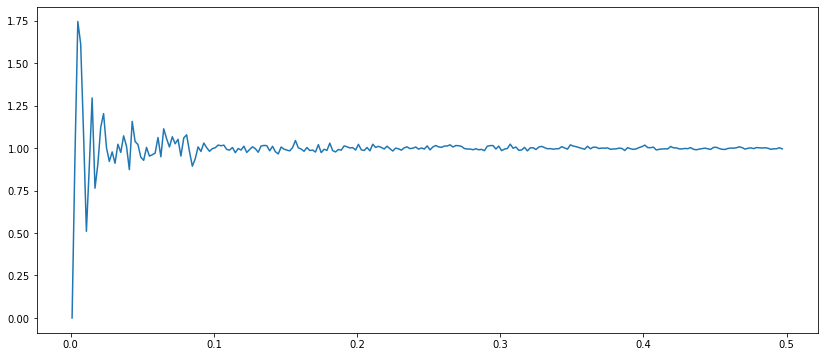

In [704]:
# radial distribution function
def calc_rdf_single( c_ref, c_all, boxsize):
    # calculates a binned (x^2+y^2) vs z binned matrix for distributions of points relative to reference point.
    c_tall = unfold_coordinates(c_all, c_ref, boxsize)-c_ref
    r = np.sqrt( c_tall[:,0]**2 + c_tall[:,1]**2 + c_tall[:,2]**2 )
    return r

def calc_rdf( c_all, boxsize):
    # calculates distances for all pairs of distributions of points

    sz = c_all.shape[0]
    rall = np.zeros( sz*(sz-1))
    for idx in np.arange(sz):
        c_aall = c_all[ np.arange(c_all.shape[0])!=idx]
        rall[idx*(sz-1):idx*(sz-1)+(sz-1)] = calc_rdf_single(
                c_all[idx,:],c_aall, boxsize)
    return rall

# Homogenous points
pts = np.random.uniform( size=(3000,3))
box_size = np.array([1,1,1])
vol = 1.0
n = pts.shape[0]
r = calc_rdf( pts,box_size)

redges = np.arange(0,0.5,0.002)
W = (4/3)*math.pi*(redges[1:]**3 - redges[:-1]**3)
H2,redges = np.histogram(r, bins=redges)
H = vol*H2/(W*n*n)

fig,ax = plt.subplots(figsize=(14, 6))
plt.plot((redges[1:]+redges[:-1])/2,H)